In [25]:
import time
import pandas as pd
import json
from bs4 import BeautifulSoup as soup
from tqdm import trange
import re 
from collections import OrderedDict
import datetime
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch, FontManager
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from highlight_text import fig_text

In [6]:
def whoscored():
    driver = webdriver.Chrome(r'C:\Users\jose\Documents\Data Science\Personal\Soccer\Football analytics\chromedriver.exe')
    website_URL="https://es.whoscored.com/Matches/1559818/Live/Espa%C3%B1a-LaLiga-2021-2022-Barcelona-Real-Sociedad"
    driver.get(website_URL)
    element=driver.find_element_by_xpath('//*[@id="layout-wrapper"]/script[1]')
    script_content=element.get_attribute('innerHTML')
    script_ls=script_content.split(sep="  ")
    script_ls=list(filter(None,script_ls))
    script_ls=[name for name in script_ls if name.strip()]
    dictstring=script_ls[2][17:-2]
    matchdict=json.loads(dictstring)
    matchdict["id"]=script_ls[1][8:-2]
    return matchdict
    driver.close()
data = whoscored()

In [7]:
data.keys()

dict_keys(['playerIdNameDictionary', 'periodMinuteLimits', 'timeStamp', 'attendance', 'venueName', 'referee', 'weatherCode', 'elapsed', 'startTime', 'startDate', 'score', 'htScore', 'ftScore', 'etScore', 'pkScore', 'statusCode', 'periodCode', 'home', 'away', 'maxMinute', 'minuteExpanded', 'maxPeriod', 'expandedMinutes', 'expandedMaxMinute', 'periodEndMinutes', 'commonEvents', 'events', 'timeoutInSeconds', 'id'])

# Cleaning data

In [8]:
events_df = pd.DataFrame(data['events'])
ids = data['playerIdNameDictionary']

# Keys from string to int
player_ids = {int(old_key): val for old_key, val in ids.items()}

#Replace player IDs
team_ID = data['home']['teamId']
team_name = data['home']['name']
events_df['PlayerName'] = events_df["playerId"].replace(player_ids)

# Replace team name
events_df['TeamName'] = events_df["teamId"].replace({team_ID : team_name})

# Replace the period
events_df["period"] = events_df["period"].apply(pd.Series)["displayName"].values

# Replace type 
events_df['type'] = events_df["type"].apply(pd.Series)["displayName"].values

# Replace the outcome
events_df['outcomeType'] = events_df["outcomeType"].apply(pd.Series)["displayName"].values

# Adjusting to pitch size

In [9]:
events_df['xx'] = (events_df['x'])*105/100
events_df['yy'] = (events_df['y'])*68/100
events_df['endxx'] = (events_df['endX'])*105/100
events_df['endyy'] = (events_df['endY'])*68/100
df = events_df

# Pitch function

In [10]:
# Setting dimensions, colour, orientation of football pitch
def football_pitch(x_min=0, x_max=105,
               y_min=0, y_max=68,
               pitch_color="#f0f0f0",
               line_color='black',
               line_thickness=1.5,
               point_size=20,
               orientation="horizontal",
               aspect="full",
               axis='off',
               ax=None
               ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")
    
    ax.axis(axis)

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # x dimension markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # y dimension markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer box
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard box
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfline, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

# Passmaps 

## Passmaps as tw uses it

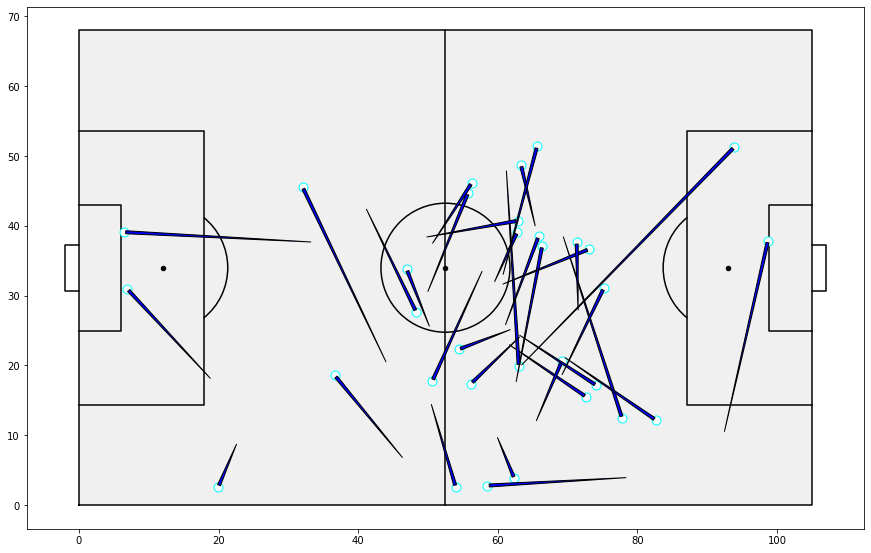

In [11]:
fig, ax = plt.subplots(figsize=(15, 11))
#Drawing a full pitch horizontally
football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='on')
df2 = df[(df["type"]=="Pass")&(df["PlayerName"]=="Frenkie de Jong")&(df["outcomeType"]=="Successful")]
ax.scatter(y=df2['endyy'], x=df2['endxx'],color='white',edgecolor='cyan',s=80)
plot_comet = lambda vals: ax.annotate('', xy=(vals[0], vals[1]), xycoords='data', xytext=(vals[2], vals[3]), 
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.3", fc="blue"))
df2[['xx', 'yy', 'endxx', 'endyy']].apply(plot_comet, axis=1);

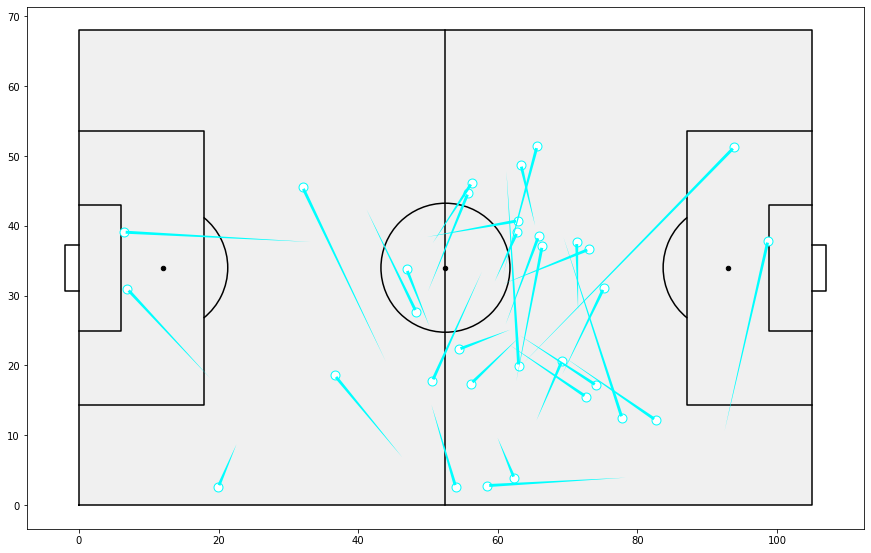

In [12]:
fig, ax = plt.subplots(figsize=(15, 11))
#Drawing a full pitch horizontally
football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='on')
df2 = df[(df["type"]=="Pass")&(df["PlayerName"]=="Frenkie de Jong")&(df["outcomeType"]=="Successful")]
ax.scatter(y=df2['endyy'], x=df2['endxx'],color='white',edgecolor='cyan',s=80)
plot_comet = lambda vals: ax.annotate('', xy=(vals[0], vals[1]), xycoords='data', xytext=(vals[2], vals[3]), 
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.3", fc="cyan",
                                                     ec="none"),color="cyan")
df2[['xx', 'yy', 'endxx', 'endyy']].apply(plot_comet, axis=1);

## For loops

In [13]:
# Eliminate NaN values
events_df = events_df[events_df["PlayerName"].notna()]
# Player names
player_names = events_df[df["TeamName"]=="Barcelona"]["PlayerName"].unique()
player_names

array(['Memphis Depay', 'Sergio Busquets', 'Frenkie de Jong',
       'Gerard Piqué', 'Jordi Alba', 'Neto', 'Martin Braithwaite',
       'Sergiño Dest', 'Eric García', 'Antoine Griezmann', 'Pedri',
       'Emerson Royal', 'Sergi Roberto', 'Ronald Araujo', 'Nico González',
       'Clément Lenglet'], dtype=object)

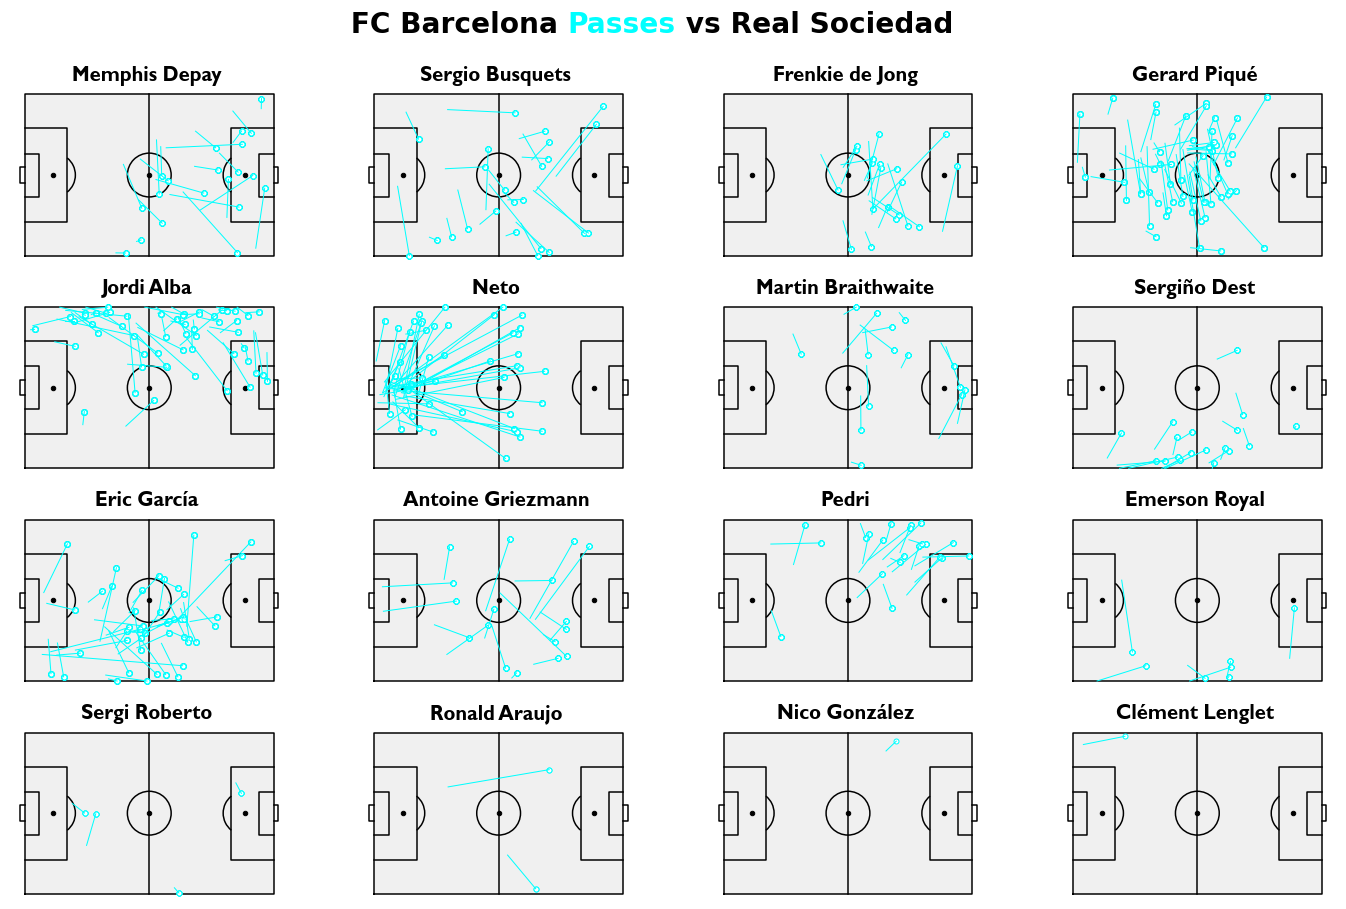

In [29]:
fig ,ax = plt.subplots(4,4,figsize=(24,15))
#football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='on')
#ax.flat[-2].set_visible(False)
#ax.flat[-1].set_visible(False)

for i,ax in enumerate(fig.axes):
    try:
        pass_viz = events_df[events_df.PlayerName==player_names[i]].reset_index()
        football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='off')
        total_pass = len(pass_viz)
        for x in range(len(pass_viz['xx'])):
            ax.scatter(y=pass_viz['endyy'], x=pass_viz['endxx'],color='white',edgecolor='cyan',s=25)
            ax.set_title("%s "%(player_names[i]), loc='center', fontsize=20, fontweight='bold', color='k',fontfamily='Gill Sans MT')
            ax.plot((pass_viz['xx'][x],pass_viz['endxx'][x]),(pass_viz['yy'][x],pass_viz['endyy'][x]),color="cyan",linewidth=1)
    except:
        pass
fig_text(.32,.95, s=" FC Barcelona <Passes> vs Real Sociedad",highlight_textprops=[{"color":'cyan'}], fontsize = 28, fontweight="bold", color = "black")

## Successful and Unsuccessful passes

In [15]:
def plot_color(row):
    if row.outcomeType == "Successful":
        return "springgreen"
    else:
        return "crimson"

events_df1 = events_df.apply(plot_color, axis='columns')
events_df["color"] = events_df1.values

<ipython-input-15-b8fcff37a44a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df["color"] = events_df1.values


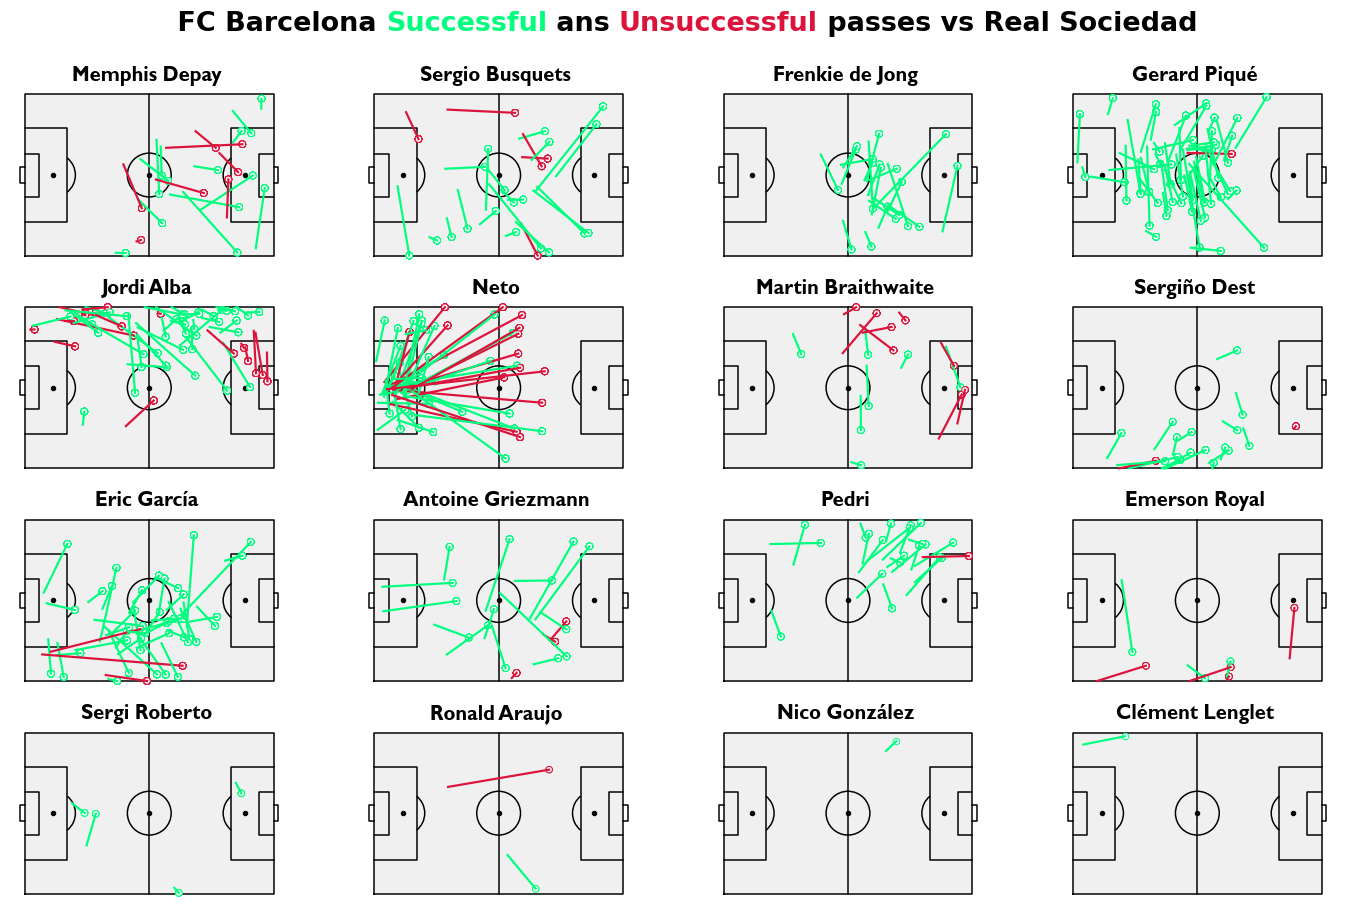

In [37]:
fig ,ax = plt.subplots(4,4,figsize=(24,15))
events_df1 = pass_viz[pass_viz["outcomeType"]=="Unsuccessful"]
#football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='on')
#ax.flat[-2].set_visible(False)
#ax.flat[-1].set_visible(False)
for i,ax in enumerate(fig.axes):
    try:
        pass_viz = events_df[events_df.PlayerName==player_names[i]].reset_index()
        football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='off')
        total_pass = len(pass_viz)
        for x in range(len(pass_viz['xx'])):
            ax.set_title("%s "%(player_names[i]), loc='center', fontsize=20, fontweight='bold', color='k',fontfamily='Gill Sans MT')
            ax.scatter(y=pass_viz['endyy'], x=pass_viz['endxx'],color='white',edgecolor=pass_viz.color.values,s=42)
            ax.plot((pass_viz['xx'][x],pass_viz['endxx'][x]),(pass_viz['yy'][x],pass_viz['endyy'][x]),color=pass_viz.color.values[x],linewidth=2.2)
    except:
        pass
fig_text(.22,.95, s=" FC Barcelona <Successful> ans <Unsuccessful> passes vs Real Sociedad",highlight_textprops=[{"color":'springgreen'},{"color":'crimson'}], fontsize = 27, fontweight="bold", color = "black")

## Progressive passes

In [17]:
events_df['ifProg'] = np.where(events_df['xx']<events_df['endxx'], True, False)

<ipython-input-17-e324df3f8e92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['ifProg'] = np.where(events_df['xx']<events_df['endxx'], True, False)


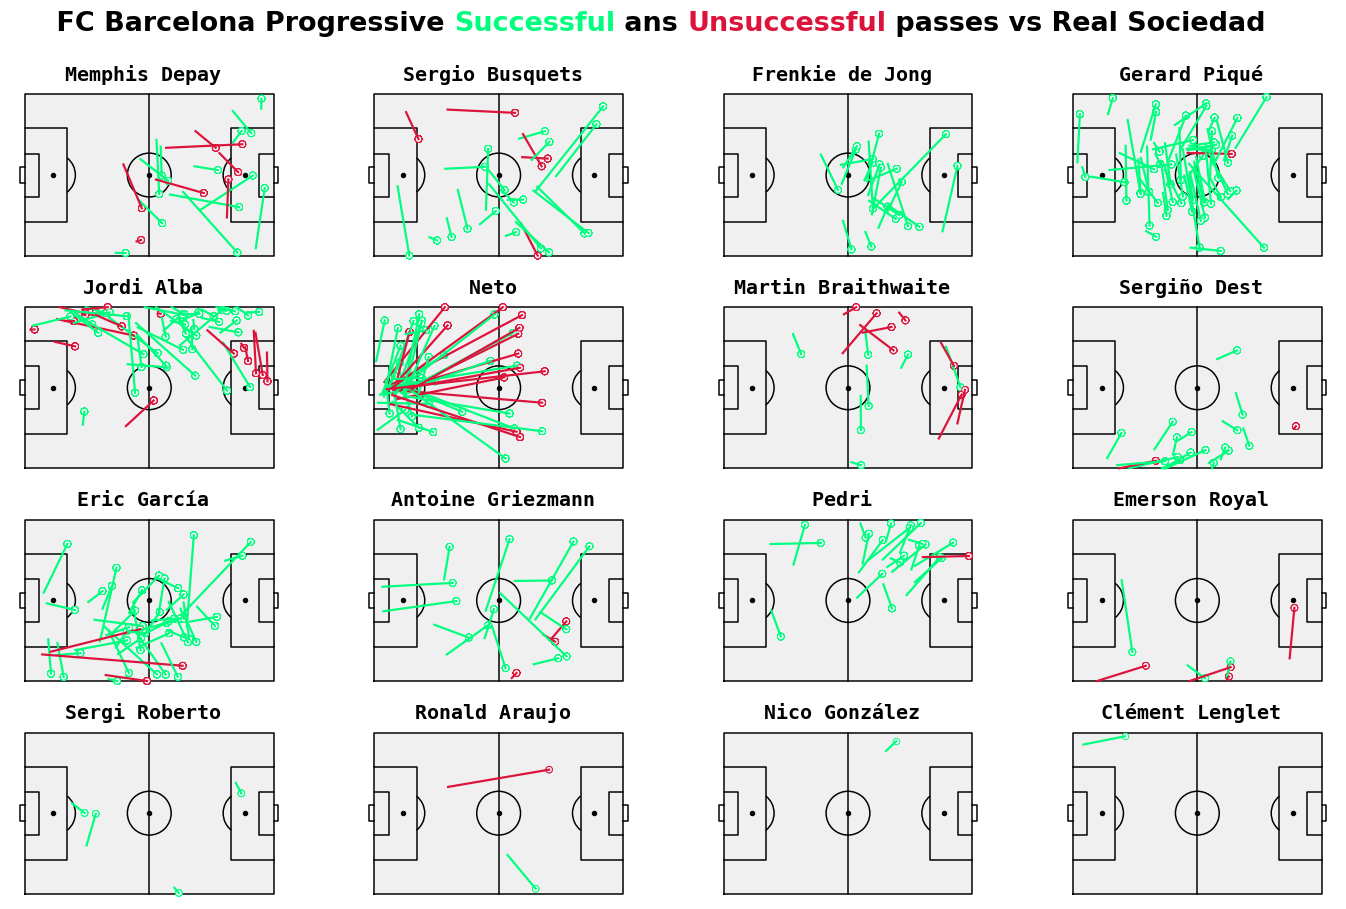

In [38]:
fig ,ax = plt.subplots(4,4,figsize=(24,15))
#football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='on')
#ax.flat[-2].set_visible(False)
#ax.flat[-1].set_visible(False)
for i,ax in enumerate(fig.axes):
    try:
        events_df = events_df[events_df["ifProg"]==True]
        pass_viz = events_df[events_df.PlayerName==player_names[i]].reset_index()
        football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='off')
        total_pass = len(pass_viz)
        for x in range(len(pass_viz['xx'])):
            ax.set_title("%s "%(player_names[i]), loc='center', fontsize=20, fontweight='bold', color='k',fontfamily='Monospace')
            ax.scatter(y=pass_viz['endyy'], x=pass_viz['endxx'],color='white',edgecolor=pass_viz.color.values,s=42)
            ax.plot((pass_viz['xx'][x],pass_viz['endxx'][x]),(pass_viz['yy'][x],pass_viz['endyy'][x]),color=pass_viz.color.values[x],linewidth=2.2)
    except:
        pass
fig_text(.15,.95, s=" FC Barcelona Progressive <Successful> ans <Unsuccessful> passes vs Real Sociedad",highlight_textprops=[{"color":'springgreen'},{"color":'crimson'}], fontsize = 27, fontweight="bold", color = "black")

## Short medium and long passes

In [19]:
events_df["Difference"] = events_df["endxx"] - events_df["xx"]


In [40]:
def plot_color(row):
    if row.Difference < 5:
        return "cyan"
    elif row.Difference < 10:
        return "crimson"
    else:
        return "springgreen"

events_df1 = events_df.apply(plot_color, axis='columns')
events_df["color_pass"] = events_df1.values

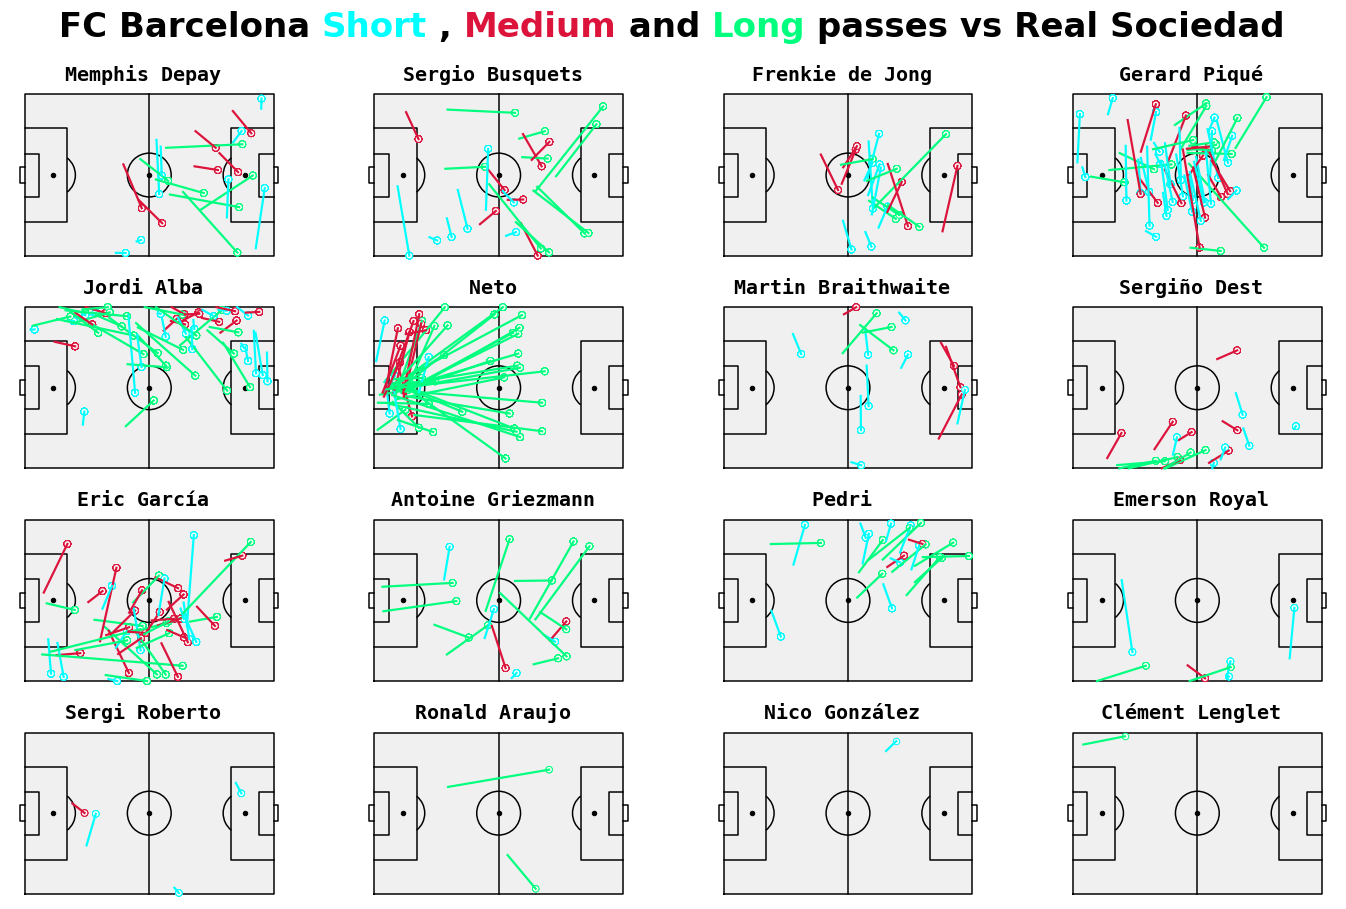

In [43]:
fig ,ax = plt.subplots(4,4,figsize=(24,15))
for i,ax in enumerate(fig.axes):
    try:
        events_df = events_df[events_df["ifProg"]==True]
        pass_viz = events_df[events_df.PlayerName==player_names[i]].reset_index()
        football_pitch(orientation="horizontal",aspect="full",line_color="black",ax=ax, axis='off')
        total_pass = len(pass_viz)
        for x in range(len(pass_viz['xx'])):
            ax.set_title("%s "%(player_names[i]), loc='center', fontsize=20, fontweight='bold', color='k',fontfamily='Monospace')
            ax.scatter(y=pass_viz['endyy'], x=pass_viz['endxx'],color='white',edgecolor=pass_viz.color_pass.values,s=42)
            ax.plot((pass_viz['xx'][x],pass_viz['endxx'][x]),(pass_viz['yy'][x],pass_viz['endyy'][x]),color=pass_viz.color_pass.values[x],linewidth=2.2)
    except:
        pass
fig_text(.15,.95, s=" FC Barcelona <Short> , <Medium> and <Long> passes vs Real Sociedad",highlight_textprops=[{"color":'cyan'},{"color":'crimson'},{"color":'springgreen'}], fontsize = 34, fontweight="bold", color = "black")

